In [2]:
import bento
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

import pickle
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import bento
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from optuna.integration import SkorchPruningCallback
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.svm import SVC
from skorch import NeuralNet, NeuralNetClassifier
from skorch.callbacks import EarlyStopping, EpochScoring
from xgboost import XGBRFClassifier

In [3]:
data = bento.io.read_h5ad("../../data/locfish/locfish_eval_20211019.h5ad")
data.shape

(10000, 1)

In [4]:
# cell_by_feature = bento.tl.get_features(data, bento.tl.PATTERN_MODEL_FEATURE_NAMES, min_count=0)
# cell_by_feature.head()

In [5]:
# List of features
features = [
    "cell_inner_proximity",
    "nucleus_inner_proximity",
    "nucleus_outer_proximity",
    "cell_inner_asymmetry",
    "nucleus_inner_asymmetry",
    "nucleus_outer_asymmetry",
    "l_max",
    "l_max_gradient",
    "l_min_gradient",
    "l_monotony",
    "l_half_radius",
    "point_dispersion",
    "nucleus_dispersion",
]

cell_by_feature = []
for f in features:
    cell_by_feature.append(data.to_df(f))
cell_by_feature = (
    pd.concat(cell_by_feature, axis=1).reset_index(drop=True).astype(float)
)
cell_by_feature.columns = features

## Prepare datasets

In [6]:
# classes = bento._utils.PATTERN_NAMES

In [7]:
classes = ["cell_edge", "cytoplasmic", "none", "nuclear", "nuclear_edge"]

Split train/test features

In [8]:
X = cell_by_feature.to_numpy()

le = LabelBinarizer().fit(classes)
y = le.transform(data.to_df("pattern").values.flatten())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=22, stratify=y
)

In [9]:
model = pickle.load(open(f"../../models/rf_calib_20220514.pkl", "rb"))

In [10]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

Class 1 - Best Threshold=0.45300, Best F1-Score=0.95285, Default F1-Score=0.95155
Class 2 - Best Threshold=0.43400, Best F1-Score=0.76617, Default F1-Score=0.75033
Class 3 - Best Threshold=0.37900, Best F1-Score=0.79075, Default F1-Score=0.76364
Class 4 - Best Threshold=0.43700, Best F1-Score=0.97015, Default F1-Score=0.96604
Class 5 - Best Threshold=0.50500, Best F1-Score=0.97494, Default F1-Score=0.97372


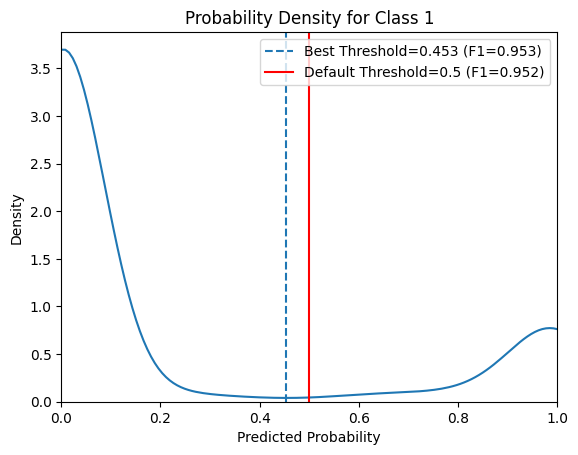

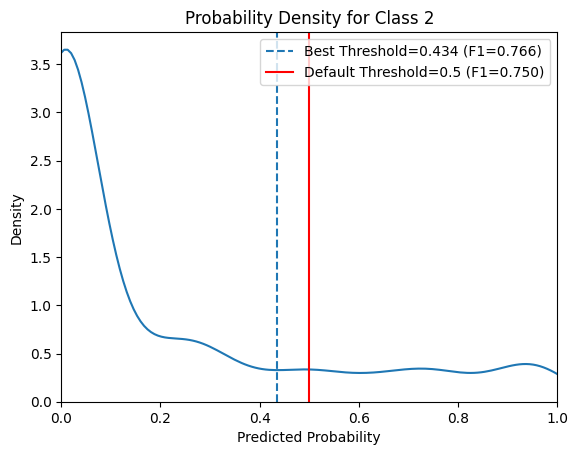

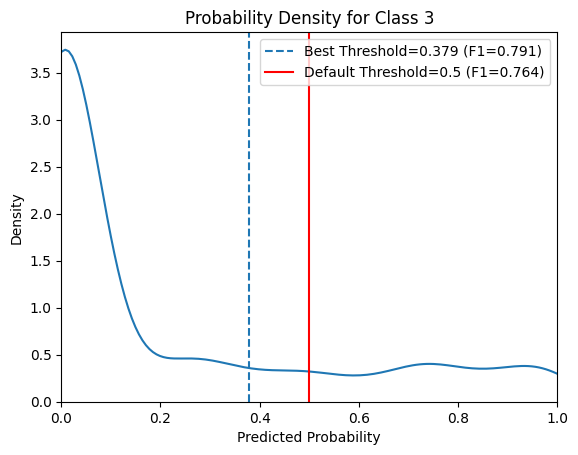

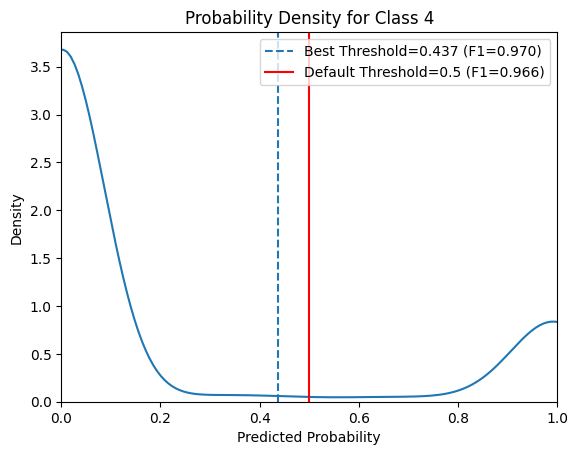

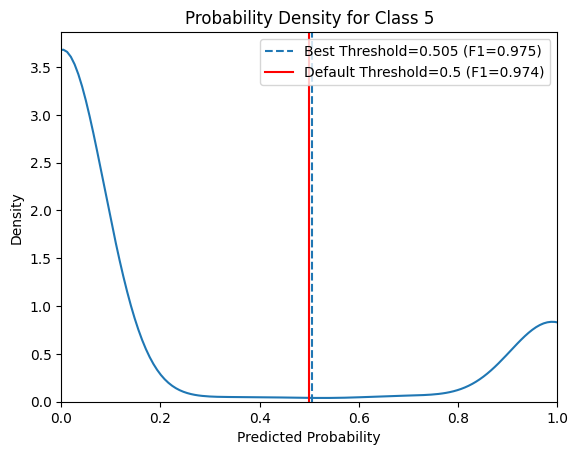

In [11]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Define thresholds
thresholds = np.arange(0, 1, 0.001)

# Get probability predictions for the test set
yhat = model.predict_proba(X_test)

# Loop through each class and plot with detailed titles and labels
for i in range(5):
    probs = yhat[:, i]
    plt.figure()
    
    # Plot the probability density
    ax = sns.kdeplot(probs)
    plt.xlim(0, 1)
    
    # Set plot titles and labels
    plt.title(f'Probability Density for Class {i+1}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    
    # Evaluate each threshold and calculate F1 scores
    default_score = f1_score(y_test[:, i], to_labels(probs, 0.5))
    scores = [f1_score(y_test[:, i], to_labels(probs, t)) for t in thresholds]
    
    # Find the best threshold
    ix = np.argmax(scores)
    best_threshold = thresholds[ix]
    best_score = scores[ix]
    
    # Mark the best threshold and the default threshold of 0.5
    ax.axvline(best_threshold, linestyle='--', label=f'Best Threshold={best_threshold:.3f} (F1={best_score:.3f})')
    ax.axvline(0.5, color='red', label=f'Default Threshold=0.5 (F1={default_score:.3f})')
    
    # Show legend for clarity
    plt.legend(loc='upper right')
    
    # Display the threshold and scores
    print(f'Class {i+1} - Best Threshold={best_threshold:.5f}, Best F1-Score={best_score:.5f}, Default F1-Score={default_score:.5f}')

# Show the plots
plt.show()


Threshold=0.45300, F-Score=0.95285, Old=0.95155
Threshold=0.43400, F-Score=0.76617, Old=0.75033
Threshold=0.37900, F-Score=0.79075, Old=0.76364
Threshold=0.43700, F-Score=0.97015, Old=0.96604
Threshold=0.50500, F-Score=0.97494, Old=0.97372


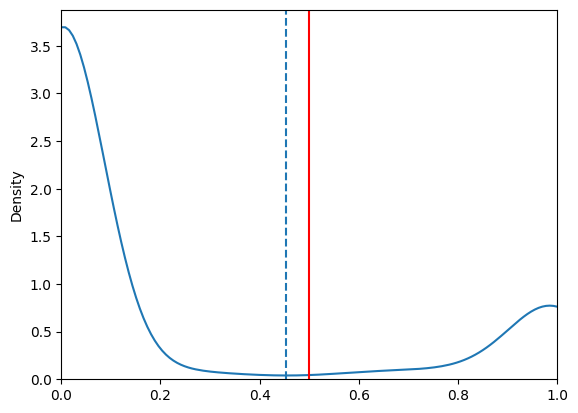

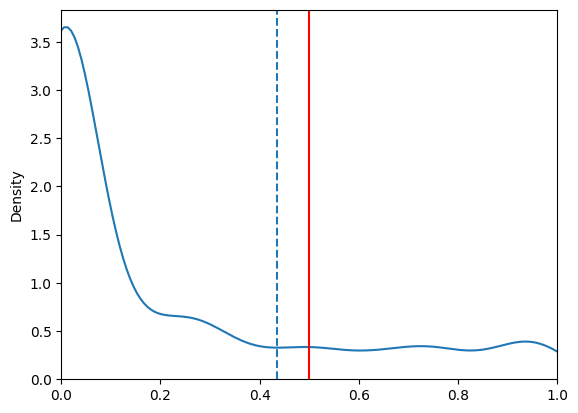

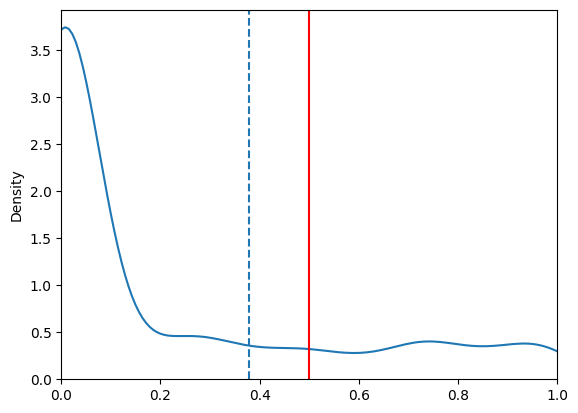

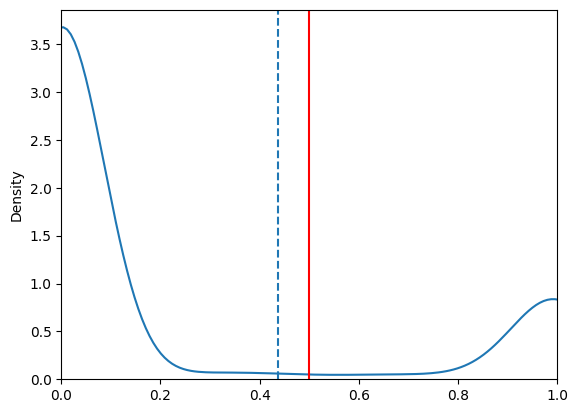

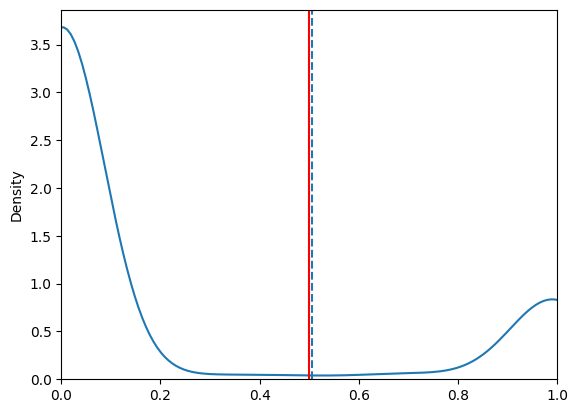

In [15]:
# keep probabilities for the positive outcome only
# define thresholds
thresholds = np.arange(0, 1, 0.001)

yhat = model.predict_proba(X_test)

for i in range(5):
    probs = yhat[:, i]
    plt.figure()
    ax = sns.kdeplot(probs)
    plt.xlim(0,1)
    # evaluate each threshold
    default_score = f1_score(y_test[:,i], to_labels(probs, 0.5))
    scores = [f1_score(y_test[:,i], to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)
    ax.axvline(thresholds[ix], linestyle='--')
    ax.axvline(0.5,color='red')
    print('Threshold=%.5f, F-Score=%.5f, Old=%.5f' % (thresholds[ix], scores[ix], default_score))

In [1]:
import pandas as pd

# List to store results
results = []

# Define thresholds
thresholds = np.arange(0, 1, 0.001)

# Get probability predictions for the test set
yhat = model.predict_proba(X_test)

# Loop through each class
for i in range(5):
    probs = yhat[:, i]
    
    # Calculate default and best scores
    default_score = f1_score(y_test[:, i], to_labels(probs, 0.5))
    scores = [f1_score(y_test[:, i], to_labels(probs, t)) for t in thresholds]
    ix = np.argmax(scores)
    best_threshold = thresholds[ix]
    best_score = scores[ix]
    
    # Append results for this class
    results.append({
        'Class': i+1,
        'Best Threshold': best_threshold,
        'Best F1-Score': best_score,
        'Default Threshold': 0.5,
        'Default F1-Score': default_score
    })

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('threshold_results.csv', index=False)


NameError: name 'np' is not defined

In [13]:
import os

# Directory to save plots
os.makedirs('plots', exist_ok=True)

# Loop through each class and save plot
for i in range(5):
    probs = yhat[:, i]
    plt.figure()
    
    # Plot probability density
    ax = sns.kdeplot(probs)
    plt.xlim(0, 1)
    
    # Set plot titles and labels
    plt.title(f'Probability Density for Class {i+1}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    
    # Calculate and mark thresholds
    default_score = f1_score(y_test[:, i], to_labels(probs, 0.5))
    scores = [f1_score(y_test[:, i], to_labels(probs, t)) for t in thresholds]
    ix = np.argmax(scores)
    best_threshold = thresholds[ix]
    
    # Mark thresholds and save plot
    ax.axvline(best_threshold, linestyle='--', label=f'Best Threshold={best_threshold:.3f} (F1={scores[ix]:.3f})')
    ax.axvline(0.5, color='red', label=f'Default Threshold=0.5 (F1={default_score:.3f})')
    plt.legend(loc='upper right')
    
    # Save each plot with a unique filename
    plt.savefig(f'plots/probability_density_class_{i+1}.png')
    plt.close()  # Close the figure to free memory
